In [1]:
import os
import numpy as np
import keras
import tensorflow as tf
import tweepy
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import string
import seaborn as sns
import nltk
import sklearn
import tweepy
import json
from wordcloud import WordCloud
from collections import Counter

from __future__ import print_function
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras import backend as K
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline
#os.getcwd()

Using TensorFlow backend.


In [2]:
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# #sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

# with tf.Session() as sess:
#     print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [3]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11810300583419026736
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3180960153
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9409580296604795251
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Twitter API ##

In [4]:
consumer_key='ggd6CdEGcktohgYVJbgkplCeM'
consumer_secret='T8lXrGE6Rz0xMnDWzR7IxL4D5WL3TSjgn2SV86vNKe49xhmEDG'
access_token='972996143474008065-Co06QR4JIP4SZH8EYuJ8LkW6PCNPslJ'
access_token_secret='huwRAC8BHAxK9i28CbVQEcuGsDw3X7jwRd5eDT1Ep61C0'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

name = "elonmusk"

my_list_of_dicts = []    
with open('tweetresults.txt', 'w') as file:
    tweets = tweepy.Cursor(api.user_timeline, screen_name = name).items(500)
    for each_json_tweet in tweets:
        my_list_of_dicts.append(each_json_tweet._json)
    file.write(json.dumps(my_list_of_dicts, indent = 4)) 
    

In [5]:
my_demo_list = []
with open('tweetresults.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        my_demo_list.append({'Text': str(text),
                             'Likes': int(favorite_count),
                             'Retweet': int(retweet_count),
                             'Date': created_at,
                             'Length': len(text)
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = 
                                  ['Text', 
                                   'Likes', 'Retweet', 
                                   'Date',
                                  'Length'])

In [6]:
print(tweet_json.head(10))

                                                Text  Likes  Retweet  \
0  RT @jack: This is an honest and fun conversati...      0     1680   
1  RT @SpaceX: Falcon 9 and Telstar 18 VANTAGE ar...      0     1076   
2                        @TheOceanCleanup Looks cool   4719      182   
3  Not easy coming up with a good cover story for...  85293     7998   
4  Test-driving our new boring machine with a 🎮 h...  40806     4859   
5  @Tesla_Bill @InsideEVs 2170 is about the right...   4379      176   
6      @caitylotz Like sands through the hourglass …   9111      289   
7  @PEpicerie 10 types of people in the world: th...   1755      177   
8  @karaswisher @themightyoo @itsmanibro Will do ...    838       32   
9  @xJawz @RNaegels @joerogan @peterthiel @reidho...   1478      124   

                             Date  Length  
0  Sun Sep 09 22:05:21 +0000 2018     140  
1  Sun Sep 09 21:17:14 +0000 2018     140  
2  Sat Sep 08 21:52:11 +0000 2018      27  
3  Sat Sep 08 21:20:46 +0000 20

In [8]:
# Data Cleanse #
tweet_json['Text'] = tweet_json['Text'].str.replace('RT @', '', case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('http\S+', '', case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('@[\w]*', '', case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('&gt', '', case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace("[^a-zA-Z#]", ' ', case=False)

# corp = u' '.join(tweet_json['Text'])
# print(len(corp))

In [9]:
# Test - Remove words <3 characters - Sentiment Analysis ONLY#
tweet_json2 = tweet_json.copy()
tweet_json2['Text'] = tweet_json2['Text'].apply(lambda x: ' '.join([w for w in x.split() if
                                                           len(w)>3]))

In [10]:
#Tokenizer#
tokens = tweet_json2['Text'].apply(lambda x: x.split())
tokens.head()

0    [jack, This, honest, conversation, between, St...
1    [SpaceX, Falcon, Telstar, VANTAGE, vertical, F...
2                                        [Looks, cool]
3    [easy, coming, with, good, cover, story, under...
4               [Test, driving, boring, machine, with]
Name: Text, dtype: object

In [11]:
#Common Word - NLTK #
# play, player, played, plays --> play #
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokens = tokens.apply(lambda x: [stemmer.stem(i)
                                         for i in x])

for i in range(len(tokens)):
    tokens[i] = ' '.join(tokens[i])
    
tweet_json2['cleantext'] = tokens
tokens.head()

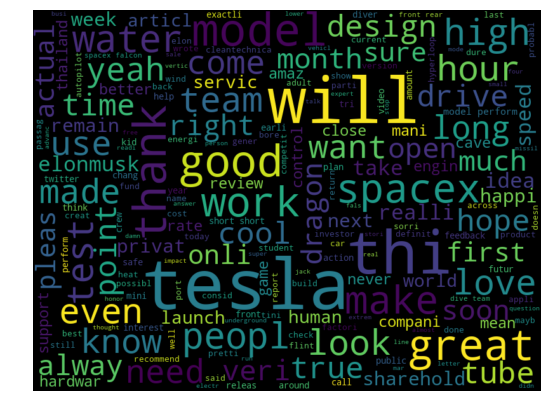

In [15]:
all_words = ' '.join([text for text in tweet_json2['cleantext']])

wordcloud = WordCloud(width=800, 
                      height=600, 
                      random_state=21, 
                      max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#If User has hashtags - Musk minimal usage#
# def hashtag_extract(x):
#     hashtags = []
#     # Loop over the words in the tweet
#     for i in x:
#         ht = re.findall(r"#(\w+)", i)
#         hashtags.append(ht)
#     return hashtags

# HT_find = hashtag_extract(tweet_json2['cleantext'])
# HT_find

In [ ]:
splt = all_words.split()
counter = Counter(splt)
d = pd.DataFrame({'words': list(counter.keys()),
                  'count': list(counter.values())})

d = d.nlargest(columns = "count", n = 10)
plt.figure(figsize = (20,5))
ax = sns.barplot(data = d, x = "words", y = "count")
plt.show()

In [ ]:
### Section 2 Below - LSTM Stock Analysis ###

In [230]:
# Character Mapping #
nchars = None

def create_index_char_map(corp):
    chars = sorted(list(set(corp)))
    chars = chars[1:]
    N_CHARS = len(chars)
    print('No. of unique characters:', N_CHARS)
    char_to_idx = {c: i for i, c in enumerate(chars)}
    idx_to_char = {i: c for i, c in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

chars, char_to_idx, idx_to_char = create_index_char_map(corp)
corp_len = len(corp)

No. of unique characters: 52


In [166]:
max_len = 40
seq_step = 3
n_seq = None

def create_sequences(corpus):
    sequences, next_chars = [], []
    for i in range(0, corp_len - max_len, seq_step):
        sequences.append(corp[i:i + max_len])
        next_chars.append(corp[i + max_len])
    global n_seq
    n_seq = len(sequences)
    print('No. of sequences:', len(sequences))
    return np.array(sequences), np.array(next_chars)

sequences, next_chars = create_sequences(corp)

No. of sequences: 6674


In [167]:
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(sequences)
# summarize what was learned
# integer encode documents
encoded_docs = t.texts_to_matrix(sequences, mode='count')
print(encoded_docs)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [170]:
def build_model(hidden_layer_size=128, dropout=0.2):
    model = Sequential()
    model.add(LSTM(hidden_layer_size, return_sequences=True, input_shape=(40, 78)))
    model.add(Dropout(dropout))
    model.add(LSTM(hidden_layer_size, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(78, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr = 0.2))
    model.summary()
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40, 128)           105984    
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 78)                10062     
Total params: 247,630
Trainable params: 247,630
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_model(model, X, y, batch_size=128, nb_epoch=60, verbose=0):
    
    checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor='loss', verbose=verbose, save_best_only=True, mode='min')
    model.fit(X, y, batch_size=batch_size, nb_epoch=nb_epoch, verbose=verbose, callbacks=[checkpointer])

train_model(model, X, y, verbose=verbose)